In [ ]:
!pip install nba-api
!pip install Keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
# dependencies

# basic
from datetime import datetime
import json
import pandas as pd
from pandas import ExcelFile
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
import requests
import seaborn as sns
import time

# nba api
import nba_api
from nba_api.stats.endpoints import BoxScoreDefensive, BoxScoreMiscV2, BoxScorePlayerTrackV2, BoxScoreUsageV2
from nba_api.stats.static import teams
from nba_api.stats.endpoints import LeagueGameFinder, LeagueGameLog, PlayerGameLog

# sklearn
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, Normalizer, StandardScaler
from sklearn.svm import SVC

# tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

-------
# csv dataset
-------

In [2]:
# df_final = pd.read_csv('/content/drive/My Drive/mo_bucks_ml/current/gamestatsfinal_version_1.csv')
df_final = pd.read_csv('gamestatsfinal_version_3.csv')

In [3]:
df_final

,AST_PCT,AST_RATIO,AST_TOV,AST,BLK,BLKA,BLK.1,CFGA,CFGM,CFG_PCT,...,TS_TEAM_AVG,UFGA,UFGM,UFG_PCT,USG_PCT,VIDEO_AVAILABLE,WL,YEAR BUILT,ARENA,ATTENDANCE
0,0.214,27.3,3.00,3,0,1,0,2,0,0.000,...,0.480333,5,3,0.600,0.163,1,W,1995,TD Garden,18624
1,0.091,11.1,1.00,2,0,2,0,6,2,0.333,...,0.480333,7,3,0.429,0.229,1,W,1995,TD Garden,18624
2,0.000,0.0,0.00,0,0,1,0,5,1,0.200,...,0.480333,7,3,0.429,0.206,1,W,1995,TD Garden,18624
3,0.095,16.7,0.67,2,4,0,4,3,3,1.000,...,0.480333,4,1,0.250,0.137,1,W,1995,TD Garden,18624
4,0.292,28.0,2.33,7,0,1,0,2,1,0.500,...,0.480333,12,1,0.083,0.247,1,W,1995,TD Garden,18624
5,0.000,0.0,0.00,0,0,0,0,1,1,1.000,...,0.480333,11,6,0.545,0.241,1,W,1995,TD Garden,18624
6,0.000,0.0,0.00,0,0,0,0,0,0,0.000,...,0.480333,0,0,0.000,0.000,1,W,1995,TD Garden,18624
7,0.048,8.3,1.00,1,1,0,1,3,0,0.000,...,0.480333,7,5,0.714,0.167,1,W,1995,TD Garden,18624
8,0.176,30.0,1.50,3,0,0,0,0,0,0.000,...,0.480333,4,2,0.500,0.109,1,W,1995,TD Garden,18624
9,0.250,13.0,3.00,3,0,0,0,5,2,0.400,...,0.480333,12,7,0.583,0.290,1,W,1995,TD Garden,18624


In [4]:
# fix gameid column w/ leading zeros
df_final['GAME_ID'] = df_final['GAME_ID'].map(lambda x: f'{x:0>10}')

In [5]:
df_final.head()

,AST_PCT,AST_RATIO,AST_TOV,AST,BLK,BLKA,BLK.1,CFGA,CFGM,CFG_PCT,...,TS_TEAM_AVG,UFGA,UFGM,UFG_PCT,USG_PCT,VIDEO_AVAILABLE,WL,YEAR BUILT,ARENA,ATTENDANCE
0,0.214,27.3,3.00,3,0,1,0,2,0,0.000,...,0.480333,5,3,0.600,0.163,1,W,1995,TD Garden,18624
1,0.091,11.1,1.00,2,0,2,0,6,2,0.333,...,0.480333,7,3,0.429,0.229,1,W,1995,TD Garden,18624
2,0.000,0.0,0.00,0,0,1,0,5,1,0.200,...,0.480333,7,3,0.429,0.206,1,W,1995,TD Garden,18624
3,0.095,16.7,0.67,2,4,0,4,3,3,1.000,...,0.480333,4,1,0.250,0.137,1,W,1995,TD Garden,18624
4,0.292,28.0,2.33,7,0,1,0,2,1,0.500,...,0.480333,12,1,0.083,0.247,1,W,1995,TD Garden,18624


# add more stats

In [ ]:
test_array = df_final['GAME_ID'].unique()[:10]
unique_array = df_final['GAME_ID'].unique()
test_df = df_final.copy()

In [ ]:
missing_games = [
'0021801226',
'0021801218'
]

In [ ]:
df_def_list = []
df_misc_list = []
df_tracking_list = []
df_usage_list = []

startTime = datetime.now()

game_ok_count = 0
game_no_count = 0

game_problem_list = []

for game in missing_games:
  
    try:

        print(f'Searching for game: {game}...')

        df_defensive = BoxScoreDefensive(game_id=game).get_data_frames()[0]
        time.sleep(1)
        print(f' 1.Defensive df found and saved')

        df_misc = BoxScoreMiscV2(game_id=game).get_data_frames()[0]
        time.sleep(1)
        print(f' 2.Misc df found and saved')

        df_tracking = BoxScorePlayerTrackV2(game_id=game).get_data_frames()[0]
        time.sleep(1)
        print(f' 3.Tracking df found and saved')

        df_usage = BoxScoreUsageV2(game_id=game).get_data_frames()[0]
        time.sleep(1)
        print(f' 4.Usage df found and saved')

#         x, = np.where(unique_array == game)
        x, = np.where(missing_games == game)

        game_ok_count += 1

        print(f'--- {x+1} games searched ---')
        print(f'--- {game_ok_count} games found ---')

        time.sleep(5)

        df_def_list.append(df_defensive)
        df_misc_list.append(df_misc)
        df_tracking_list.append(df_tracking)
        df_usage_list.append(df_usage)

        print(f'--- {game_ok_count} games appended ---')

        print(f'--- Time: {datetime.now() - startTime} ---')

    except:
    
    #   problem list
        game_no_count += 1

        game_problem_list.append(game)

        print(f'game {game} encountered timeout')
        print(f'--- {game_no_count} games with problems ---')

    #   sleep
        print(f'--- sleeping for 300 seconds ---')
        time.sleep(300)

    #   try again to search
        try:

            print(f'Searching again for game: {game}...')

            df_defensive = BoxScoreDefensive(game_id=game).get_data_frames()[0]
            time.sleep(1)
            print(f' 1.Defensive df found and saved')

            df_misc = BoxScoreMiscV2(game_id=game).get_data_frames()[0]
            time.sleep(1)
            print(f' 2.Misc df found and saved')

            df_tracking = BoxScorePlayerTrackV2(game_id=game).get_data_frames()[0]
            time.sleep(1)
            print(f' 3.Tracking df found and saved')

            df_usage = BoxScoreUsageV2(game_id=game).get_data_frames()[0]
            time.sleep(1)
            print(f' 4.Usage df found and saved')

            x, = np.where(unique_array == game)

            game_ok_count += 1

            print(f'--- {x+1} games searched ---')
            print(f'--- {game_ok_count} games found ---')

            time.sleep(5)

            df_def_list.append(df_defensive)
            df_misc_list.append(df_misc)
            df_tracking_list.append(df_tracking)
            df_usage_list.append(df_usage)

            print(f'--- {game_ok_count} games appended ---')

            print(f'--- Time: {datetime.now() - startTime} ---')

        except:

            print(f'game {game} encountered another timeout')
            print(f'--- {game_no_count} games with problems ---')

        #   sleep
            print(f'--- sleeping for 300 seconds ---')
            time.sleep(300)

            continue

    continue

# df_def_all = pd.concat(df_def_list)
# df_misc_all = pd.concat(df_misc_list)
# df_tracking_all = pd.concat(df_tracking_list)
# df_usage_all = pd.concat(df_usage_list)

df_def_missing = pd.concat(df_def_list)
df_misc_missing = pd.concat(df_misc_list)
df_tracking_missing = pd.concat(df_tracking_list)
df_usage_missing = pd.concat(df_usage_list)

print(f'--- merged df ---')

In [ ]:
df_def_all.to_csv('defensive.csv')
df_misc_all.to_csv('misc.csv')
df_tracking_all.to_csv('tracking.csv')
df_usage_all.to_csv('usage.csv')

In [ ]:
# stats_df = test_df.merge(df_def_all, on=['GAME_ID','PLAYER_ID','TEAM_ID'], how='outer')
stats_df = test_df.merge(df_def_missing, on=['GAME_ID','PLAYER_ID','TEAM_ID'], how='outer')

In [ ]:
# stats_df = test_df.merge(df_misc_all, on=['GAME_ID','PLAYER_ID','TEAM_ID'], how='outer')
stats_df = test_df.merge(df_misc_missing, on=['GAME_ID','PLAYER_ID','TEAM_ID'], how='outer')

In [ ]:
# stats_df = test_df.merge(df_tracking_all, on=['GAME_ID','PLAYER_ID','TEAM_ID'], how='outer')
stats_df = test_df.merge(df_tracking_missing, on=['GAME_ID','PLAYER_ID','TEAM_ID'], how='outer')

In [ ]:
# stats_df = test_df.merge(df_usage_all, on=['GAME_ID','PLAYER_ID','TEAM_ID'], how='outer')
stats_df = test_df.merge(df_usage_missing, on=['GAME_ID','PLAYER_ID','TEAM_ID'], how='outer')

In [ ]:
stats_df

--------
# svc model (grid)
--------

In [6]:
list(df_final.keys())

['AST_PCT',
 'AST_RATIO',
 'AST_TOV',
 'AST',
 'BLK',
 'BLKA',
 'BLK.1',
 'CFGA',
 'CFGM',
 'CFG_PCT',
 'COMMENT',
 'Capacity',
 'Capacity_pct',
 'City',
 'DEF_RATING',
 'DFGA',
 'DFGM',
 'DFG_PCT',
 'DIST',
 'DRBC',
 'DREB_PCT',
 'DREB',
 'EFG_EVAL',
 'EFG_PCT',
 'EFG_TEAM_AVG',
 'E_DEF_RATING',
 'E_NET_RATING',
 'E_OFF_RATING',
 'E_PACE',
 'E_USG_PCT',
 'FG3A',
 'FG3M',
 'FG3_PCT',
 'FGA',
 'FGM',
 'FG_PCT',
 'FTA',
 'FTAST',
 'FTM',
 'FT_PCT',
 'FT_missed',
 'GAME_DATE',
 'GAME_ID',
 'Gamescore',
 'Home/Away',
 'Hometeam',
 'MATCHUP',
 'MATCHUP_AST',
 'MATCHUP_FG3A',
 'MATCHUP_FG3M',
 'MATCHUP_FG3_PCT',
 'MATCHUP_FGA',
 'MATCHUP_FGM',
 'MATCHUP_FG_PCT',
 'MATCHUP_MIN',
 'MATCHUP_TOV',
 'MIN',
 'MIN_FLAT',
 'NET_RATING',
 'OFF_RATING',
 'OPP_PTS_2ND_CHANCE',
 'OPP_PTS_FB',
 'OPP_PTS_OFF_TOV',
 'OPP_PTS_PAINT',
 'ORBC',
 'OREB',
 'OREB_PCT',
 'PACE',
 'PACE_PER40',
 'PARTIAL_POSS',
 'PASS',
 'PCT_AST',
 'PCT_BLK',
 'PCT_BLKA',
 'PCT_DREB',
 'PCT_FG3A',
 'PCT_FG3M',
 'PCT_FGA',
 'PCT_F

In [41]:
features = [
    
#   target
    'WL',
    
#   traditional
    # 'PTS',
    # 'AST',
    'PF',
#   'DEF_RATING',
#   'OFF_RATING',
    'FG_PCT',
    'FG3M',
    'FTM',
    'FGM',
    'STL',
    'TOV',
    'Home/Away',
    
#   minutes/usage/possession
    'MIN_FLAT',
    # 'USG_PCT',
    'POSS',
    
#   point types
    'PTS_2ND_CHANCE',
    'PTS_FB',
    'PTS_OFF_TOV',
    'PTS_PAINT',

#   advanced
    'Gamescore',
    'EFG_PCT',
    'TS_PCT',
#   eval => pct above or below team average
    'EFG_EVAL',
    'TS_EVAL',
    
#   granular
    'SPD', # speed
    'DIST', # distance
    'ORBC', # oreb chances
    'DRBC', # dreb chances
    'RBC', # reb chances
    'TCHS', # touches
    'SAST', # secondary assists
    'FTAST', # free throw assists
    'PFD', # personal fouls drawn
    'PASS', # passes
    'CFGM', # contested fgm
    'CFGA', # contested fga
    'CFG_PCT', # contested fg pct
    'UFGM', # uncontested fgm
    'UFGA', # uncontested fga
    'UFG_PCT', # uncontested fg pct
    'DFGM', # defended fgm
    'DFGA', # defended fga
    'DFG_PCT', # defended df pct
    
#   percent of team stats
    'PCT_FGM',
    'PCT_FGA',
    'PCT_FG3M',
    'PCT_FG3A',
    'PCT_FTM',
    'PCT_FTA',
    'PCT_OREB',
    'PCT_DREB',
    'PCT_REB',
    'PCT_AST',
    'PCT_TOV',
    'PCT_STL',
    'PCT_BLK',
    'PCT_BLKA',
    'PCT_PF',
    'PCT_PFD',
    'PCT_PTS',
    
#     arena
    'Capacity_pct',
#     'Capacity',
    
]

In [42]:
df_svc = df_final[features].copy()

In [43]:
df_svc.head()

,WL,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,Home/Away,MIN_FLAT,...,PCT_REB,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,Capacity_pct
0,W,3,0.429,2,0,3,0,1,HOME,19,...,0.211,0.375,0.167,0.000,0.0,0.500,0.375,0.444,0.190,1.0
1,W,4,0.385,1,1,5,0,2,HOME,28,...,0.172,0.105,0.286,0.000,0.0,0.667,0.364,0.077,0.171,1.0
2,W,1,0.333,1,1,4,4,0,HOME,25,...,0.172,0.000,0.000,0.667,0.0,0.500,0.111,0.385,0.192,1.0
3,W,1,0.571,0,1,4,0,3,HOME,30,...,0.121,0.118,0.300,0.000,1.0,0.000,0.091,0.143,0.134,1.0
4,W,1,0.143,1,2,2,0,3,HOME,29,...,0.129,0.389,0.333,0.000,0.0,0.250,0.077,0.143,0.103,1.0


In [44]:
encoder = LabelEncoder()
encoder.fit(df_svc['WL'])
y = encoder.transform(df_svc.WL)
df_svc['y'] = y

In [45]:
encoder = LabelEncoder()
encoder.fit(df_svc['Home/Away'])
home = encoder.transform(df_svc['Home/Away'])
df_svc['HOME'] = home

In [46]:
df_svc

,WL,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,Home/Away,MIN_FLAT,...,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,Capacity_pct,y,HOME
0,W,3,0.429,2,0,3,0,1,HOME,19,...,0.167,0.000,0.000,0.500,0.375,0.444,0.190,1.000000,1,1
1,W,4,0.385,1,1,5,0,2,HOME,28,...,0.286,0.000,0.000,0.667,0.364,0.077,0.171,1.000000,1,1
2,W,1,0.333,1,1,4,4,0,HOME,25,...,0.000,0.667,0.000,0.500,0.111,0.385,0.192,1.000000,1,1
3,W,1,0.571,0,1,4,0,3,HOME,30,...,0.300,0.000,1.000,0.000,0.091,0.143,0.134,1.000000,1,1
4,W,1,0.143,1,2,2,0,3,HOME,29,...,0.333,0.000,0.000,0.250,0.077,0.143,0.103,1.000000,1,1
5,W,5,0.583,2,0,7,2,1,HOME,21,...,0.200,0.667,0.000,0.000,0.500,0.143,0.327,1.000000,1,1
6,W,0,0.000,0,0,0,0,0,HOME,1,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000000,1,1
7,W,0,0.500,1,0,5,0,1,HOME,27,...,0.167,0.000,0.333,0.000,0.000,0.111,0.180,1.000000,1,1
8,W,2,0.500,2,1,2,0,2,HOME,25,...,0.200,0.000,0.000,0.000,0.182,0.125,0.152,1.000000,1,1
9,W,2,0.529,1,4,9,1,1,HOME,29,...,0.091,0.250,0.000,0.000,0.167,0.231,0.426,1.000000,1,1


In [47]:
target = df_svc['y']
data = df_svc.drop(['WL', 'y', 'Home/Away'], axis=1)
feature_names = data.columns

In [48]:
data

,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,MIN_FLAT,POSS,PTS_2ND_CHANCE,...,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,Capacity_pct,HOME
0,3,0.429,2,0,3,0,1,19,42,0,...,0.375,0.167,0.000,0.000,0.500,0.375,0.444,0.190,1.000000,1
1,4,0.385,1,1,5,0,2,28,64,2,...,0.105,0.286,0.000,0.000,0.667,0.364,0.077,0.171,1.000000,1
2,1,0.333,1,1,4,4,0,25,54,3,...,0.000,0.000,0.667,0.000,0.500,0.111,0.385,0.192,1.000000,1
3,1,0.571,0,1,4,0,3,30,68,0,...,0.118,0.300,0.000,1.000,0.000,0.091,0.143,0.134,1.000000,1
4,1,0.143,1,2,2,0,3,29,66,0,...,0.389,0.333,0.000,0.000,0.250,0.077,0.143,0.103,1.000000,1
5,5,0.583,2,0,7,2,1,21,45,4,...,0.000,0.200,0.667,0.000,0.000,0.500,0.143,0.327,1.000000,1
6,0,0.000,0,0,0,0,0,1,4,0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000000,1
7,0,0.500,1,0,5,0,1,27,57,0,...,0.143,0.167,0.000,0.333,0.000,0.000,0.111,0.180,1.000000,1
8,2,0.500,2,1,2,0,2,25,53,3,...,0.429,0.200,0.000,0.000,0.000,0.182,0.125,0.152,1.000000,1
9,2,0.529,1,4,9,1,1,29,64,2,...,0.300,0.091,0.250,0.000,0.000,0.167,0.231,0.426,1.000000,1


In [49]:
# X_train, X_test, y_train, y_test = train_test_split(data[:5000], target[:5000], random_state=42)

X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [50]:
y_train.head()

13443    1
6311     0
12709    1
14408    1
11633    0
Name: y, dtype: int64

In [51]:
y_test.head()

20252    0
20634    0
516      1
2250     0
5354     1
Name: y, dtype: int64

In [52]:
X_test

,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,MIN_FLAT,POSS,PTS_2ND_CHANCE,...,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,Capacity_pct,HOME
20252,3,0.643,2,5,9,0,2,37,77,0,...,0.214,0.286,0.000,0.000,0.500,0.136,0.200,0.298,0.851073,0
20634,0,0.182,1,2,2,0,2,20,43,0,...,0.250,0.250,0.000,0.000,1.000,0.000,0.375,0.233,1.000000,1
516,3,0.500,2,0,4,0,1,23,51,0,...,0.182,0.143,0.000,0.000,0.000,0.231,0.000,0.204,0.980567,0
2250,3,0.615,2,1,8,1,7,34,76,0,...,0.450,0.467,0.200,0.000,0.000,0.200,0.059,0.218,1.002604,1
5354,0,0.400,0,0,2,0,2,21,43,0,...,0.091,0.400,0.000,0.000,0.333,0.000,0.000,0.078,0.805384,0
12136,0,0.000,0,0,0,0,0,0,2,0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000000,1
4903,1,0.800,3,1,4,1,3,17,40,0,...,0.100,0.333,1.000,0.500,0.000,0.250,0.125,0.267,0.722648,1
2992,4,0.600,2,0,6,0,3,28,63,4,...,0.000,0.188,0.000,1.000,0.500,0.364,0.154,0.212,1.000000,0
6239,0,1.000,0,0,2,0,0,4,7,0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.803900,0
16791,1,0.400,0,2,4,0,3,21,47,4,...,0.000,0.429,0.000,0.000,0.200,0.111,0.125,0.270,1.000000,0


In [53]:
model = SVC(C= 1, 
        gamma= 0.001, 
        kernel= 'rbf',
        verbose=True)

In [54]:
model.fit(X_train, y_train)

[LibSVM]

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)

In [55]:
predictions_svc = model.predict(X_test)

In [56]:
X_test['predictions_svc'] = predictions_svc
X_test['target'] = target

/Users/andrew/anaconda3/envs/bootcamp/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/andrew/anaconda3/envs/bootcamp/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [57]:
X_test

,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,MIN_FLAT,POSS,PTS_2ND_CHANCE,...,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,Capacity_pct,HOME,predictions_svc,target
20252,3,0.643,2,5,9,0,2,37,77,0,...,0.000,0.000,0.500,0.136,0.200,0.298,0.851073,0,0,0
20634,0,0.182,1,2,2,0,2,20,43,0,...,0.000,0.000,1.000,0.000,0.375,0.233,1.000000,1,0,0
516,3,0.500,2,0,4,0,1,23,51,0,...,0.000,0.000,0.000,0.231,0.000,0.204,0.980567,0,0,1
2250,3,0.615,2,1,8,1,7,34,76,0,...,0.200,0.000,0.000,0.200,0.059,0.218,1.002604,1,0,0
5354,0,0.400,0,0,2,0,2,21,43,0,...,0.000,0.000,0.333,0.000,0.000,0.078,0.805384,0,0,1
12136,0,0.000,0,0,0,0,0,0,2,0,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000000,1,1,1
4903,1,0.800,3,1,4,1,3,17,40,0,...,1.000,0.500,0.000,0.250,0.125,0.267,0.722648,1,1,0
2992,4,0.600,2,0,6,0,3,28,63,4,...,0.000,1.000,0.500,0.364,0.154,0.212,1.000000,0,0,1
6239,0,1.000,0,0,2,0,0,4,7,0,...,0.000,0.000,0.000,0.000,0.000,1.000,0.803900,0,1,1
16791,1,0.400,0,2,4,0,3,21,47,4,...,0.000,0.000,0.200,0.111,0.125,0.270,1.000000,0,0,0


In [58]:
X_test[['target', 'predictions_svc']]

,target,predictions_svc
20252,0,0
20634,0,0
516,1,0
2250,0,0
5354,1,0
12136,1,1
4903,0,1
2992,1,0
6239,1,1
16791,0,0


In [59]:
print(classification_report(y_test, predictions_svc, target_names=['Loss','Win']))

              precision    recall  f1-score   support

        Loss       0.61      0.60      0.61      2725
         Win       0.63      0.64      0.64      2891

    accuracy                           0.62      5616
   macro avg       0.62      0.62      0.62      5616
weighted avg       0.62      0.62      0.62      5616



In [66]:
list(df_final.keys())

['AST_PCT',
 'AST_RATIO',
 'AST_TOV',
 'AST',
 'BLK',
 'BLKA',
 'BLK.1',
 'CFGA',
 'CFGM',
 'CFG_PCT',
 'COMMENT',
 'Capacity',
 'Capacity_pct',
 'City',
 'DEF_RATING',
 'DFGA',
 'DFGM',
 'DFG_PCT',
 'DIST',
 'DRBC',
 'DREB_PCT',
 'DREB',
 'EFG_EVAL',
 'EFG_PCT',
 'EFG_TEAM_AVG',
 'E_DEF_RATING',
 'E_NET_RATING',
 'E_OFF_RATING',
 'E_PACE',
 'E_USG_PCT',
 'FG3A',
 'FG3M',
 'FG3_PCT',
 'FGA',
 'FGM',
 'FG_PCT',
 'FTA',
 'FTAST',
 'FTM',
 'FT_PCT',
 'FT_missed',
 'GAME_DATE',
 'GAME_ID',
 'Gamescore',
 'Home/Away',
 'Hometeam',
 'MATCHUP',
 'MATCHUP_AST',
 'MATCHUP_FG3A',
 'MATCHUP_FG3M',
 'MATCHUP_FG3_PCT',
 'MATCHUP_FGA',
 'MATCHUP_FGM',
 'MATCHUP_FG_PCT',
 'MATCHUP_MIN',
 'MATCHUP_TOV',
 'MIN',
 'MIN_FLAT',
 'NET_RATING',
 'OFF_RATING',
 'OPP_PTS_2ND_CHANCE',
 'OPP_PTS_FB',
 'OPP_PTS_OFF_TOV',
 'OPP_PTS_PAINT',
 'ORBC',
 'OREB',
 'OREB_PCT',
 'PACE',
 'PACE_PER40',
 'PARTIAL_POSS',
 'PASS',
 'PCT_AST',
 'PCT_BLK',
 'PCT_BLKA',
 'PCT_DREB',
 'PCT_FG3A',
 'PCT_FG3M',
 'PCT_FGA',
 'PCT_F

In [71]:
dfpred = pd.concat([df_final, X_test], axis=1)

In [78]:
dfplayerpred = dfpred[['PLAYER_NAME', 'TEAM_NICKNAME', 'MATCHUP', 'predictions_svc', 'target', 'WL']].copy().dropna()

In [79]:
dfplayerpred

,PLAYER_NAME,TEAM_NICKNAME,MATCHUP,predictions_svc,target,WL
3,Al Horford,Celtics,BOS vs. PHI,1.0,1.0,W
6,Semi Ojeleye,Celtics,BOS vs. PHI,1.0,1.0,W
17,T.J. McConnell,76ers,PHI @ BOS,0.0,0.0,L
19,Dario Saric,76ers,PHI @ BOS,0.0,0.0,L
31,Klay Thompson,Warriors,GSW vs. OKC,0.0,1.0,W
34,Terrance Ferguson,Thunder,OKC @ GSW,0.0,0.0,L
35,Paul George,Thunder,OKC @ GSW,0.0,0.0,L
41,Eric Bledsoe,Bucks,MIL @ CHA,0.0,1.0,W
42,Malcolm Brogdon,Bucks,MIL @ CHA,0.0,1.0,W
44,Donte DiVincenzo,Bucks,MIL @ CHA,1.0,1.0,W


In [82]:
dfplayerpred['correct_svc'] = 0

In [85]:
for index, row in dfplayerpred.iterrows():
    
    if row['predictions_svc'] == row['target']:
        dfplayerpred.loc[index, 'correct_svc'] = 'correct'
    if row['predictions_svc'] != row['target']:
        dfplayerpred.loc[index, 'correct_svc'] = 'wrong'

In [86]:
dfplayerpred

,PLAYER_NAME,TEAM_NICKNAME,MATCHUP,predictions_svc,target,WL,correct_svc
3,Al Horford,Celtics,BOS vs. PHI,1.0,1.0,W,correct
6,Semi Ojeleye,Celtics,BOS vs. PHI,1.0,1.0,W,correct
17,T.J. McConnell,76ers,PHI @ BOS,0.0,0.0,L,correct
19,Dario Saric,76ers,PHI @ BOS,0.0,0.0,L,correct
31,Klay Thompson,Warriors,GSW vs. OKC,0.0,1.0,W,wrong
34,Terrance Ferguson,Thunder,OKC @ GSW,0.0,0.0,L,correct
35,Paul George,Thunder,OKC @ GSW,0.0,0.0,L,correct
41,Eric Bledsoe,Bucks,MIL @ CHA,0.0,1.0,W,wrong
42,Malcolm Brogdon,Bucks,MIL @ CHA,0.0,1.0,W,wrong
44,Donte DiVincenzo,Bucks,MIL @ CHA,1.0,1.0,W,correct


## grid

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [ ]:
model = SVC()

# param_grid = {'C': [0.001, 0.1, 1, 5, 10, 100],
#               'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
#               'kernel':['rbf']}

param_grid = {'C': [0.001, 0.01, 0.1, 1, 5],
              'gamma': [0.001, 0.01, 0.1, 1],
              'kernel':['rbf']}

grid = GridSearchCV(model, param_grid, verbose=3)

In [ ]:
grid.fit(X_train, y_train)

In [ ]:
grid.best_params_

In [ ]:
grid.best_score_

In [ ]:
predictions_grid = grid.predict(X_test)

In [ ]:
predictions_grid

In [ ]:
print(classification_report(y_test, predictions_grid,
                            target_names=["loss", "win"]))

In [ ]:

matrix = confusion_matrix(y_test, predictions_grid)
sns.heatmap(matrix.T, annot=True, fmt='d', cbar=False,
            xticklabels=['Loss', 'Win'],
            yticklabels=['Loss', 'Win'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
matrix.T

----------
# neural net
----------

In [8]:
df_nnet = df_final[features]

In [9]:
data = df_nnet.copy()

In [10]:
data.head()

,WL,PF,FG_PCT,FG3M,FTM,FGM,STL,TOV,Home/Away,MIN_FLAT,...,PCT_REB,PCT_AST,PCT_TOV,PCT_STL,PCT_BLK,PCT_BLKA,PCT_PF,PCT_PFD,PCT_PTS,Capacity_pct
0,W,3,0.429,2,0,3,0,1,HOME,19,...,0.211,0.375,0.167,0.000,0.0,0.500,0.375,0.444,0.190,1.0
1,W,4,0.385,1,1,5,0,2,HOME,28,...,0.172,0.105,0.286,0.000,0.0,0.667,0.364,0.077,0.171,1.0
2,W,1,0.333,1,1,4,4,0,HOME,25,...,0.172,0.000,0.000,0.667,0.0,0.500,0.111,0.385,0.192,1.0
3,W,1,0.571,0,1,4,0,3,HOME,30,...,0.121,0.118,0.300,0.000,1.0,0.000,0.091,0.143,0.134,1.0
4,W,1,0.143,1,2,2,0,3,HOME,29,...,0.129,0.389,0.333,0.000,0.0,0.250,0.077,0.143,0.103,1.0


In [11]:
encoder = LabelEncoder()
encoder.fit(data['WL'])
encoder.classes_
y = encoder.transform(data.WL)
y

array([1, 1, 1, ..., 0, 0, 0])

In [12]:
encoder = LabelEncoder()
encoder.fit(data['Home/Away'])
home = encoder.transform(data['Home/Away'])
data['HOME'] = home

In [13]:
data.drop(columns=['WL','Home/Away'], inplace=True)
X = data.values
X

array([[3.        , 0.429     , 2.        , ..., 0.19      , 1.        ,
        1.        ],
       [4.        , 0.385     , 1.        , ..., 0.171     , 1.        ,
        1.        ],
       [1.        , 0.333     , 1.        , ..., 0.192     , 1.        ,
        1.        ],
       ...,
       [1.        , 0.5       , 0.        , ..., 0.143     , 1.01918626,
        0.        ],
       [1.        , 0.462     , 2.        , ..., 0.484     , 1.01918626,
        0.        ],
       [2.        , 0.4       , 0.        , ..., 0.098     , 1.01918626,
        0.        ]])

In [14]:
len(y), len(X)

(22462, 22462)

In [15]:
y_categorical = to_categorical(y)
y_categorical

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, random_state=1)

In [17]:
X_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train)

# X_scaler = StandardScaler().fit(X_train)
# y_scaler = StandardScaler().fit(y_train)

In [18]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [19]:
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [20]:
X_train_scaled[0]

array([0.        , 0.25      , 0.21428571, 0.13636364, 0.14285714,
       0.125     , 0.09090909, 0.39285714, 0.46153846, 0.        ,
       0.35294118, 0.17647059, 0.        , 0.25503356, 0.25      ,
       0.3       , 0.28831035, 0.29755066, 0.70679012, 0.42056075,
       0.09090909, 0.3       , 0.28947368, 0.33333333, 0.        ,
       0.        , 0.05555556, 0.28571429, 0.        , 0.08      ,
       0.        , 0.2       , 0.38461538, 0.3       , 0.15384615,
       0.0952381 , 1.        , 0.176     , 0.267     , 0.429     ,
       0.308     , 0.167     , 0.167     , 0.        , 0.136     ,
       0.111     , 0.375     , 0.167     , 0.333     , 0.        ,
       1.        , 0.        , 0.091     , 0.203     , 0.89733444,
       1.        ])

In [21]:
y_train_scaled[0]

array([0., 1.], dtype=float32)

In [22]:
X_train_scaled.shape, y_train_scaled.shape

((16846, 56), (16846, 2))

In [23]:
model = Sequential(name='NBA_Model')

# input layer
model.add(Dense(units=50, activation='relu', input_dim=X_train_scaled.shape[1], kernel_initializer='he_normal'))

# hidden layers
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=75, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=25, activation='relu'))

# output layer
# model.add(Dense(units=y_train.shape[1], activation='sigmoid'))
model.add(Dense(units=y_train.shape[1], activation='softmax'))

In [24]:
model.summary()

Model: "NBA_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                2850      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 75)                7575      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_5 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 52

In [25]:
optimizer_sgd = SGD(lr = 0.01, 
                    momentum = 0.9)

In [26]:
model.compile(
#     optimizer='adam',
    optimizer=optimizer_sgd,
#     loss='binary_crossentropy',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=100,
    shuffle=True,
    verbose=2,
    validation_data=[X_test_scaled, y_test_scaled]
)

Train on 16846 samples, validate on 5616 samples
Epoch 1/100
16846/16846 - 1s - loss: 0.6694 - accuracy: 0.5911 - val_loss: 0.6667 - val_accuracy: 0.5963
Epoch 2/100
16846/16846 - 1s - loss: 0.6477 - accuracy: 0.6250 - val_loss: 0.6374 - val_accuracy: 0.6362
Epoch 3/100
16846/16846 - 1s - loss: 0.6316 - accuracy: 0.6422 - val_loss: 0.6432 - val_accuracy: 0.6243
Epoch 4/100
16846/16846 - 1s - loss: 0.6164 - accuracy: 0.6596 - val_loss: 0.6213 - val_accuracy: 0.6514
Epoch 5/100
16846/16846 - 1s - loss: 0.6119 - accuracy: 0.6656 - val_loss: 0.6298 - val_accuracy: 0.6453
Epoch 6/100
16846/16846 - 1s - loss: 0.6036 - accuracy: 0.6717 - val_loss: 0.6207 - val_accuracy: 0.6581
Epoch 7/100
16846/16846 - 1s - loss: 0.6021 - accuracy: 0.6740 - val_loss: 0.6046 - val_accuracy: 0.6704
Epoch 8/100
16846/16846 - 1s - loss: 0.5994 - accuracy: 0.6778 - val_loss: 0.6070 - val_accuracy: 0.6660
Epoch 9/100
16846/16846 - 1s - loss: 0.5948 - accuracy: 0.6809 - val_loss: 0.6089 - val_accuracy: 0.6683
Epoch 

Epoch 78/100
16846/16846 - 1s - loss: 0.4563 - accuracy: 0.7756 - val_loss: 0.7191 - val_accuracy: 0.6725
Epoch 79/100
16846/16846 - 1s - loss: 0.4558 - accuracy: 0.7747 - val_loss: 0.7015 - val_accuracy: 0.6727
Epoch 80/100
16846/16846 - 1s - loss: 0.4469 - accuracy: 0.7807 - val_loss: 0.7195 - val_accuracy: 0.6481
Epoch 81/100
16846/16846 - 1s - loss: 0.4494 - accuracy: 0.7789 - val_loss: 0.7050 - val_accuracy: 0.6708
Epoch 82/100
16846/16846 - 1s - loss: 0.4454 - accuracy: 0.7830 - val_loss: 0.7037 - val_accuracy: 0.6681
Epoch 83/100
16846/16846 - 1s - loss: 0.4437 - accuracy: 0.7825 - val_loss: 0.7884 - val_accuracy: 0.6535
Epoch 84/100
16846/16846 - 1s - loss: 0.4411 - accuracy: 0.7861 - val_loss: 0.7112 - val_accuracy: 0.6547
Epoch 85/100
16846/16846 - 1s - loss: 0.4333 - accuracy: 0.7892 - val_loss: 0.7276 - val_accuracy: 0.6695
Epoch 86/100
16846/16846 - 1s - loss: 0.4244 - accuracy: 0.7950 - val_loss: 0.7235 - val_accuracy: 0.6448
Epoch 87/100
16846/16846 - 1s - loss: 0.4224 -

In [28]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test_scaled, verbose=2)
print(f"Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

5616/1 - 0s - loss: 0.6617 - accuracy: 0.6455
Neural Network - Loss: 0.7850032282351089, Accuracy: 0.6454772353172302


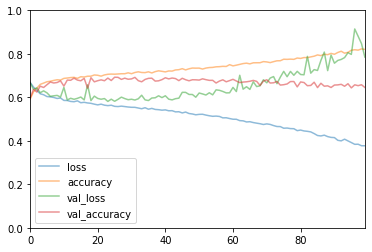

In [29]:
pd.DataFrame(model.history.history).plot(alpha=.5)
plt.gca().set_ylim(0,1)
plt.show()

In [30]:
predictions_nnet = model.predict(X_test_scaled)
predictions_nnet

array([[6.2639129e-01, 3.7360868e-01],
       [9.9997807e-01, 2.1981814e-05],
       [8.9081281e-01, 1.0918719e-01],
       ...,
       [7.5842615e-04, 9.9924159e-01],
       [7.0772582e-01, 2.9227418e-01],
       [3.9991227e-01, 6.0008776e-01]], dtype=float32)

In [31]:
y_test

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [ ]:
list(predictions_grid)

In [36]:
df_predictions = pd.DataFrame({'win': y_test[:,1], 
                               'nnet_loss': predictions_nnet[:,0], 'nnet_win': predictions_nnet[:,1],
#                                'grid_pred': predictions_grid
                              })

In [ ]:
df_predictions['nnet_eval'] = 0

In [37]:
df_predictions

,win,nnet_loss,nnet_win
0,0.0,0.626391,0.373609
1,0.0,0.999978,0.000022
2,1.0,0.890813,0.109187
3,0.0,0.745004,0.254996
4,1.0,0.443753,0.556247
5,0.0,0.608939,0.391061
6,1.0,0.341336,0.658664
7,0.0,0.461267,0.538733
8,1.0,0.976400,0.023600
9,0.0,0.150527,0.849473


In [38]:
for index, row in df_predictions.iterrows():
    
    if df_predictions.loc[index, 'nnet_loss'] > 0.5 and row['win'] == 0.0:
        df_predictions.loc[index, 'nnet_eval'] = 'correct'
        print('correct')
    
    if df_predictions.loc[index, 'nnet_win'] > 0.5 and row['win'] == 1.0:
        df_predictions.loc[index, 'nnet_eval'] = 'correct'
        print('correct')
        
#     if row['nnet_loss'] < 0.5 and row['win'] == 1.0:
#         df_predictions.loc[index, 'nnet_eval'] = 'wrong'
    
#     if row['nnet_win'] > 0.5 and row['win'] == 0.0:
#         df_predictions.loc[index, 'nnet_eval'] = 'wrong'
        
    
#     print(row)

correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct


correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct


correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct


correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct
correct


In [39]:
df_predictions

,win,nnet_loss,nnet_win,nnet_eval
0,0.0,0.626391,0.373609,correct
1,0.0,0.999978,0.000022,correct
2,1.0,0.890813,0.109187,NaN
3,0.0,0.745004,0.254996,correct
4,1.0,0.443753,0.556247,correct
5,0.0,0.608939,0.391061,correct
6,1.0,0.341336,0.658664,correct
7,0.0,0.461267,0.538733,NaN
8,1.0,0.976400,0.023600,NaN
9,0.0,0.150527,0.849473,NaN


In [40]:
df_predictions['nnet_eval'].value_counts() / len(df_predictions['nnet_eval'])

correct    0.645477
Name: nnet_eval, dtype: float64

In [ ]:
len(df_predictions['nnet_eval'])

# random forest

In [ ]:
df_forest = df_final[features].copy()

In [ ]:
target = df_forest["WL"]
target_names = ["W", "L"]

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_forest['Home/Away'])
home = encoder.transform(df_forest['Home/Away'])
df_forest['HOME'] = home

In [ ]:
data = df_forest.drop(["WL",'Home/Away'], axis=1)
feature_names = data.columns
data.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

In [ ]:
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

In [ ]:
sorted(zip(rf.feature_importances_, feature_names), reverse=True)